# KyFromAbove Explorer November Stats

This project takes data from an AWS Athena DataCatalog database table for the [KyFromAbove Open Data on AWS](https://registry.opendata.aws/kyfromabove/) from the [KyFromAbove Exploerer](https://explore.kyfromabove.ky.gov/) for the month of November.  For simplicity and security reasons, I performed the query in Athena and just exported the results to CSV.  This way, I'm not providing access information to AWS, plus not having to query, paginate, and refresh a token.  Even though these log files are public requests to publicly-available data, I ommited the fields `bucketowner` and `requester`.

```sql
    SELECT "bucket_name", "requestdatetime", "remoteip", "requestid", "operation", "key",
           "request_uri", "httpstatus", "errorcode", "bytessent", "objectsize", "totaltime", 
           "turnaroundtime", "referrer", "useragent", "hostid", "sigv", "ciphersuite", "authtype", "endpoint", 
           "tlsversion", "accesspointarn", "aclrequired", "year", "month"
    FROM "s3_access_logs_db"."kyfromabove_monthly"
    WHERE year = '2024'
        and month = '11'
```

Download the [CSV]( 'https://ky.box.com/shared/static/h55nx1ca7ztcuzqvf8tu4g5q48t6lmqk.csv') (4.18 GB) data file<br>
Download the [GZIP](https://ky.box.com/shared/static/i51gwqpefsgwyooodjtuy0ima6w8u6xg.gz) (667 MB) compressed csv data file.


___

## Project Questions

 - How many GET requests is the KyFromAbove S3 Bucket receiving from the KyFromAbove Explorer.
 - How many bytes are getting sent?
 - What are the most popular images?
 - Who is using the data?

___

## Read the data using pandas

In [1]:
# Install modules
# %pip install pandas
# %pip install matplotlib

In [2]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
# add my csv file path
csv_file = './athena_output.csv'

# read as a dataframe
logs = pd.read_csv(
    csv_file, 
    header=0, 
    dtype=
    {'httpstatus': str,  # columns popped out as mixed Dtype
     'totaltime': str   # so I just assigned them as strings
    }
) 

logs.head(2)

,bucket_name,requestdatetime,remoteip,requestid,operation,key,request_uri,httpstatus,errorcode,bytessent,...,hostid,sigv,ciphersuite,authtype,endpoint,tlsversion,accesspointarn,aclrequired,year,month
0,kyfromabove,01/Nov/2024:01:06:01 +0000,205.204.186.53,QTJ7FBZE48QH5D8H,REST.GET.OBJECT,imagery/orthos/Phase3/KY_KYAPED_2022_Season2_3...,"""GET /imagery/orthos/Phase3/KY_KYAPED_2022_Sea...",206,-,8388608.0,...,rjNpjShwbo9kejjPpS7tb1qNc4gyrgM60SMJZ+M8Ljv2E0...,SigV4,ECDHE-RSA-AES128-GCM-SHA256,AuthHeader,kyfromabove.s3-accelerate.amazonaws.com,TLSv1.2,-,-,2024,11
1,kyfromabove,01/Nov/2024:00:52:13 +0000,205.204.186.53,ECTKE7FSKM0ZJAAX,REST.GET.OBJECT,imagery/orthos/Phase3/KY_KYAPED_2022_Season2_3...,"""GET /imagery/orthos/Phase3/KY_KYAPED_2022_Sea...",206,-,8388608.0,...,J++KLUf90CFdJgr1BnqftCHmgwr8BCRn3j33v7S1CbVG9L...,SigV4,ECDHE-RSA-AES128-GCM-SHA256,AuthHeader,kyfromabove.s3-accelerate.amazonaws.com,TLSv1.2,-,-,2024,11


#### Drop columns

In [4]:
# print columns
logs.columns

Index(['bucket_name', 'requestdatetime', 'remoteip', 'requestid', 'operation',
       'key', 'request_uri', 'httpstatus', 'errorcode', 'bytessent',
       'objectsize', 'totaltime', 'turnaroundtime', 'referrer', 'useragent',
       'versionid', 'hostid', 'sigv', 'ciphersuite', 'authtype', 'endpoint',
       'tlsversion', 'accesspointarn', 'aclrequired', 'year', 'month'],
      dtype='object')

Since I know that the values for `bucket_name` will be the same for all rows, I can drop that column.  Also, because this database table is partitioned based on `year` and`month`, I can drop these values.  

I also know that I'm looking for requests that come from the KyFromAbove Explorer, so I will also filter the dataframe for values `referrer=https://explore.kyfromabove.ky.gov/`.  I'm also only looking for GET request.

In [5]:
# drop bucket_name, year, and month
logs = logs.drop(['bucket_name', 'year', 'month'], axis=1)

# filter for the referrer and the GET requests
logs_filtered = logs[
    (logs['referrer'] == '"https://explore.kyfromabove.ky.gov/"') &
    (logs['operation'].str.contains('GET'))
]

# drop nulls
logs_filtered = logs_filtered.dropna()

# Print some info
print(f"The unfiltered dataset has this for it's shape value: {logs.shape}\n")
print(f'The total amount of get requests for oblique imagery for November was {logs_filtered.shape[0]}\n')  # just to get an idea of the data
logs_filtered.head(2)

The unfiltered dataset has this for it's shape value: (6612895, 23)

The total amount of get requests for oblique imagery for November was 1833589



,requestdatetime,remoteip,requestid,operation,key,request_uri,httpstatus,errorcode,bytessent,objectsize,...,useragent,versionid,hostid,sigv,ciphersuite,authtype,endpoint,tlsversion,accesspointarn,aclrequired
28,01/Nov/2024:13:36:14 +0000,76.164.247.31,FZA403P7YDGX2A83,REST.GET.OBJECT,imagery/obliques/Phase3/KY_KYAPED_2023_Season1...,"""GET /imagery/obliques/Phase3/KY_KYAPED_2023_S...",206,-,124356.0,196243277.0,...,"""Mozilla/5.0 (Windows NT 10.0; Win64; x64) App...",-,HqnRwBfEe58hNcCsvLqLSBYd42TuWvNkdk3wTzE3b2fyDl...,-,TLS_CHACHA20_POLY1305_SHA256,-,kyfromabove.s3.amazonaws.com,TLSv1.3,-,-
29,01/Nov/2024:13:36:14 +0000,76.164.247.31,FZA5ZD81V105J7RR,REST.GET.OBJECT,imagery/obliques/Phase3/KY_KYAPED_2023_Season1...,"""GET /imagery/obliques/Phase3/KY_KYAPED_2023_S...",206,-,133883.0,196243277.0,...,"""Mozilla/5.0 (Windows NT 10.0; Win64; x64) App...",-,Tru4iNSRS11CvpD3iU6kNQHnRv1NOUKm4h4OLa49VIeUYg...,-,TLS_CHACHA20_POLY1305_SHA256,-,kyfromabove.s3.amazonaws.com,TLSv1.3,-,-


In [6]:
# check the columns
logs_filtered.columns

Index(['requestdatetime', 'remoteip', 'requestid', 'operation', 'key',
       'request_uri', 'httpstatus', 'errorcode', 'bytessent', 'objectsize',
       'totaltime', 'turnaroundtime', 'referrer', 'useragent', 'versionid',
       'hostid', 'sigv', 'ciphersuite', 'authtype', 'endpoint', 'tlsversion',
       'accesspointarn', 'aclrequired'],
      dtype='object')

#### Drop more columns

After review, we can drop requestid, errorcode, versionid, hostid, sigv, ciphersuite, authtype, tlsversion, accesspointarn, aclrequired and of course, referrer, operation, and request_uri.  These valuse don't mean anything regarding the questions I'm asking.

In [7]:
logs_filtered = logs_filtered.drop([
    'requestid', 'errorcode', 'versionid', 'hostid', 'sigv', 'ciphersuite', 'authtype',
    'tlsversion', 'accesspointarn', 'aclrequired', 'referrer', 'operation', 'request_uri'],
    axis=1)

print(logs_filtered.shape)
logs_filtered.head(2)

(1833589, 10)


,requestdatetime,remoteip,key,httpstatus,bytessent,objectsize,totaltime,turnaroundtime,useragent,endpoint
28,01/Nov/2024:13:36:14 +0000,76.164.247.31,imagery/obliques/Phase3/KY_KYAPED_2023_Season1...,206,124356.0,196243277.0,45,44,"""Mozilla/5.0 (Windows NT 10.0; Win64; x64) App...",kyfromabove.s3.amazonaws.com
29,01/Nov/2024:13:36:14 +0000,76.164.247.31,imagery/obliques/Phase3/KY_KYAPED_2023_Season1...,206,133883.0,196243277.0,41,39,"""Mozilla/5.0 (Windows NT 10.0; Win64; x64) App...",kyfromabove.s3.amazonaws.com


#### More review, drop more columns

Looking at the dataframe above, I can see a few things that aren't really necessary.  We can filter "GET" from operation or request_uri.  I'll drop request_uri because it has a lot less characters and could probably save a little memory space.  Also, because of the earlier filter of referrer, the endpoint is likely the same for all rows. 

Object size isn't too important, but I can leave it in for some easy calculations (eg., object size / bytes sent or object size / totaltime or turnaround time)

In [8]:
# drop endpoint
logs_filtered = logs_filtered.drop(['endpoint'], axis=1)
logs_filtered.columns

Index(['requestdatetime', 'remoteip', 'key', 'httpstatus', 'bytessent',
       'objectsize', 'totaltime', 'turnaroundtime', 'useragent'],
      dtype='object')

___

## Data Cleaning and Preparation

In [9]:
# review column datatypes
print(logs_filtered.dtypes)

requestdatetime     object
remoteip            object
key                 object
httpstatus          object
bytessent          float64
objectsize         float64
totaltime           object
turnaroundtime      object
useragent           object
dtype: object


In this section, I'm going to format the `requestdatetime` values so that it's just a day/month/year without a time stamp.

In [10]:
# convert timestamp to datetime object
logs_filtered['formatted_date'] = pd.to_datetime(logs_filtered['requestdatetime'], format='%d/%b/%Y:%H:%M:%S %z')
# Format the datetime objects to "Day/Month/Year"
logs_filtered['formatted_date'] = logs_filtered['formatted_date'].dt.strftime('%d/%m/%Y')

print(logs_filtered['formatted_date'])

28         01/11/2024
29         01/11/2024
30         01/11/2024
31         01/11/2024
32         01/11/2024
              ...    
6612291    30/11/2024
6612292    30/11/2024
6612892    30/11/2024
6612893    30/11/2024
6612894    30/11/2024
Name: formatted_date, Length: 1833589, dtype: object


#### Extract the file name from key variable

In [11]:
# get basefile name
logs_filtered['filename'] = logs_filtered['key'].apply(os.path.basename)
logs_filtered['filename'].head(2)

28    Color_6146_14210.tif
29    Color_6146_14210.tif
Name: filename, dtype: object

##### Copy to new dataframe so we can come back to it for different purposes

In [12]:
# create a new dataframe for neatness
logs_cleaned = logs_filtered.dropna()

---

### Calculate some values for different columns

In [13]:
# Convert totaltime to numeric and explicitly cast to float
logs_cleaned.loc[:, 'totaltime'] = pd.to_numeric(logs_cleaned['totaltime'], errors='coerce')

# Calculate bytes sent per second
bytessent_rate = logs_cleaned['bytessent'] / logs_cleaned['totaltime']
bytessent_rate_mean = bytessent_rate.mean()/1000
print(f'The average bytes sent rate is {bytessent_rate_mean.round(2)} megabytes per second.')

The average bytes sent rate is 3.19 megabytes per second.


#### Do some grouping stats

In [14]:
# sum the number or rows for distinct filenames
total_get_requests = logs_cleaned.groupby('filename').size().sort_values(ascending=False)
total_get_requests.head(20)

filename
Color_6052_19794.tif               14628
Color_6052_19795.tif                2865
Color_3121_16993.tif                2162
Color_10059_1337.tif                1989
Color_3155_8310.tif                 1800
Color_7045_41298.tif                1731
Left_6079_31571.tif                 1633
Color_20240226_11133_095834.tif     1329
Color_3121_16992.tif                1316
Color_20240225_11084_80368.tif      1299
Color_7135_11245.tif                1279
Right_4061_23097.tif                1270
Color_20240225_11084_80370.tif      1256
Color_6051_12324.tif                1205
Color_20240225_11084_80369.tif      1117
Color_2061_6050.tif                 1106
Color_2059_6990.tif                 1086
Color_10046_242622.tif              1080
Color_3155_8311.tif                 1042
Right_4056_21576.tif                1036
dtype: int64

I can see that *Color_6052_19794* has the most and this makes sense, it's the default image when the app starts up.
lets drop it.

In [15]:

total_get_requests = total_get_requests.reset_index(name='file_requests')
total_get_requests = total_get_requests[total_get_requests['filename'] != 'Color_6052_19794.tif']
total_get_requests.head(20)

,filename,file_requests
1,Color_6052_19795.tif,2865
2,Color_3121_16993.tif,2162
3,Color_10059_1337.tif,1989
4,Color_3155_8310.tif,1800
5,Color_7045_41298.tif,1731
6,Left_6079_31571.tif,1633
7,Color_20240226_11133_095834.tif,1329
8,Color_3121_16992.tif,1316
9,Color_20240225_11084_80368.tif,1299
10,Color_7135_11245.tif,1279


#### Print some charts

- Get the total daily requests
- print a chart of daily requests

In [16]:
total_requests = logs_cleaned.shape[0]
print(f'Total GET Request of Kentucky Oblique files: {total_requests: ,} requests\n')
total_daily_requests = logs_cleaned.groupby('formatted_date').size().reset_index(name='get_requests')
total_daily_requests

Total GET Request of Kentucky Oblique files:  1,833,589 requests



,formatted_date,get_requests
0,01/11/2024,79166
1,02/11/2024,17672
2,03/11/2024,12198
3,04/11/2024,78362
4,05/11/2024,22979
5,06/11/2024,83809
6,07/11/2024,99024
7,08/11/2024,66629
8,09/11/2024,6006
9,10/11/2024,5045


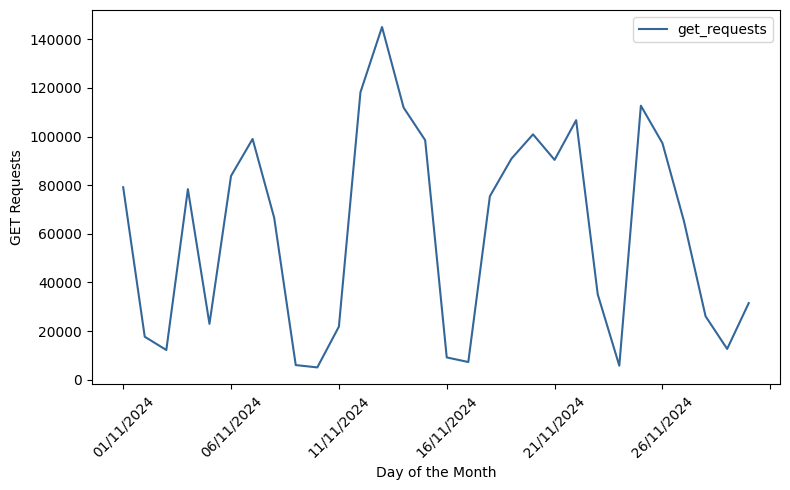

In [17]:
# plot the daily requests
total_daily_requests.plot(
    kind='line',
    x='formatted_date',
    y='get_requests',
    rot=45,
    color='#336699',
    figsize=(8,5)
).set(
    xlabel='Day of the Month',
    ylabel='GET Requests'
)

plt.tight_layout()  # Adjust layout to avoid overlapping labels
plt.show()          # Display the plot

### Who is using the data?
 
 - identify who uses the most
 - transform into a map

 For this part, we  will go use the `logs_filtered` dataframe because we want to capture all the users

In [32]:
users = logs_filtered.groupby('remoteip').size().sort_values(ascending=False).reset_index(name='requests')
users.head(20)

,remoteip,requests
0,205.204.186.54,70480
1,206.214.113.217,50683
2,65.34.44.229,50346
3,205.204.186.53,44782
4,96.29.41.191,39568
5,75.117.229.211,36289
6,216.68.58.178,34856
7,12.38.210.106,33997
8,96.11.117.106,30875
9,76.35.248.15,29101
